Tutorial 6: Results
===================

In the previous tutorials, each search returned a `Result` object, which we used to plot the maximum log likelihood
fit each model-fit. In this tutorial, we'll take a look at the result object in a little more detail.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

Lets use the model-fit performed in tutorial 1 to get a `Result` object.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphIsothermal),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.SphExponential),
    )
)

search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_1_non_linear_search",
    nlive=40,
)

analysis = al.AnalysisImaging(dataset=imaging)

result = search.fit(model=model, analysis=analysis)

INFO:root:tutorial_1_non_linear_search already completed, skipping non-linear search.


__Tracer & Fit__

In the previous tutorials, we saw that this result contains the maximum log likelihood tracer and fit, which provide
a fast way to visualize the result.

(Uncomment the line below to plot the tracer).

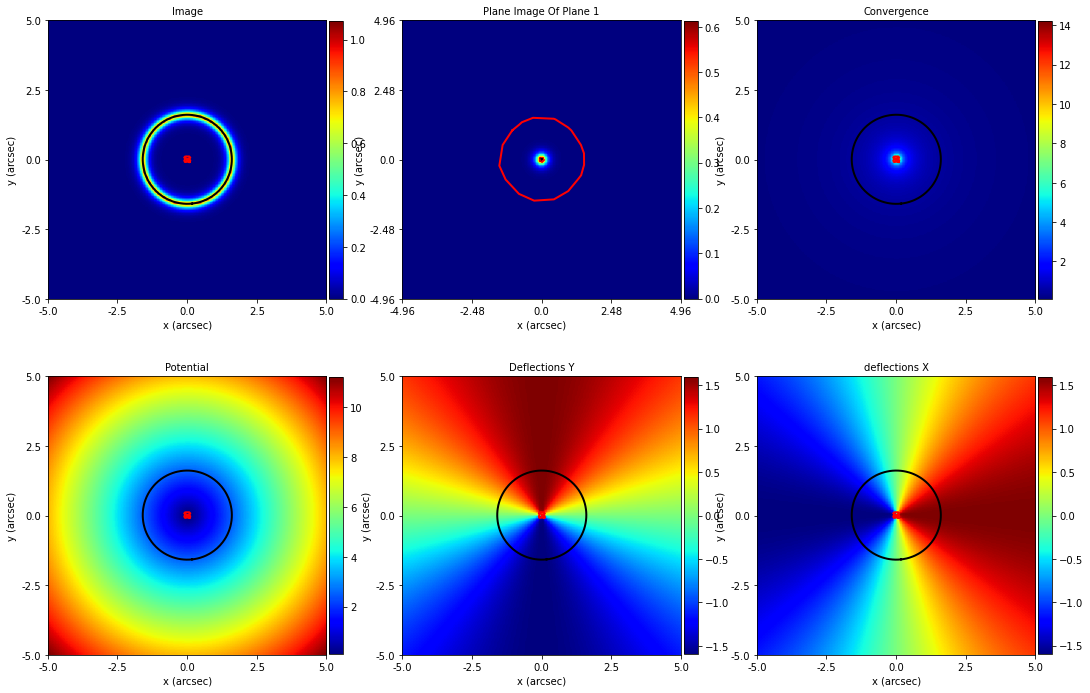

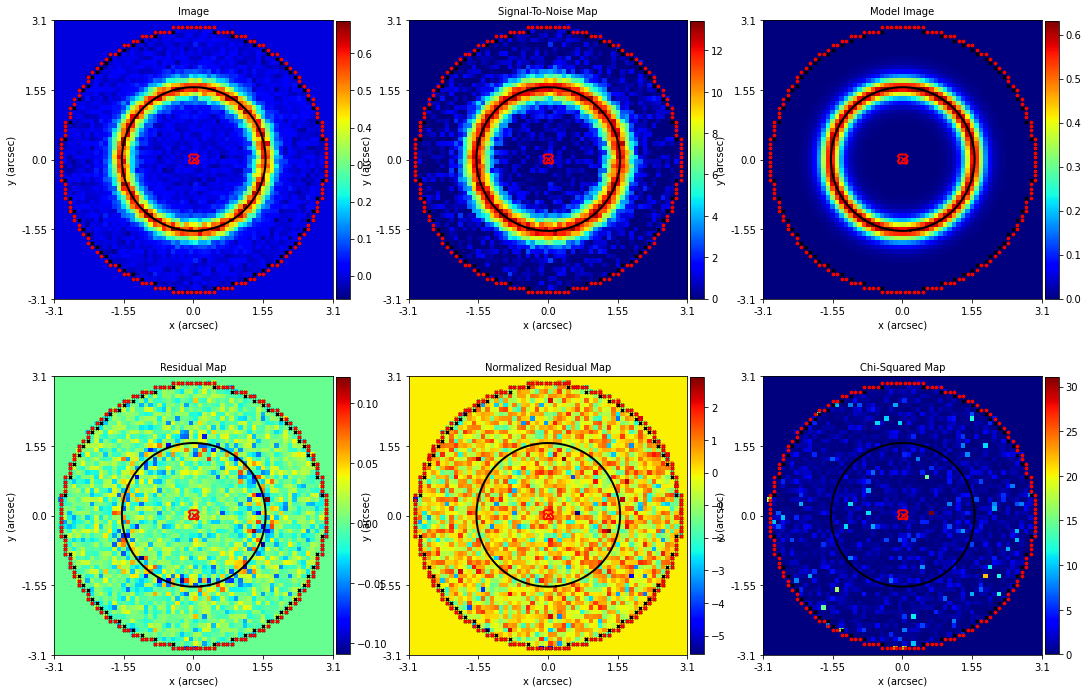

In [3]:
tracer_plotter = aplt.TracerPlotter(
    tracer=result.max_log_likelihood_tracer, grid=mask.unmasked_grid_sub_1
)
tracer_plotter.subplot_tracer()

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

__Samples__

The result contains a lot more information about the model-fit. For example, its `Samples` object contains the complete
set of non-linear search samples, including the parameters of every successful lens model evaluation and their log 
likelihood values. These are used for computing information about the model-fit, such as the most probably parameter
estimates and the error inferred for every parameter.

In [4]:
print(result.samples)
print("Parameters of 100th Sample:")
print(result.samples.parameters[99][:])
print("Log Likelihood of 100th Sample:")
print(result.samples.log_likelihoods[99])

Parameters of 100th Sample:
[0.0813025279352342, 0.08136961373643012, 0.7527762338856525, 0.028585878612578556, -0.08901148672807495, 0.001034734724232532, 28.61987439373386]
Log Likelihood of 100th Sample:
-20893.220498243474


__Workspace__

However, we are not going into any more detail on the result variable in this tutorial, or in the **HowToLens** 
lectures.

A comprehensive description of the results can be found at the following script:

 `autolens_workspace/notebooks/imaging/modeling/result.py`


__Database__

Once a search has completed running, we have a set of results on our hard disk which we can manually inspect and 
analyse. Alternatively, we can return the results from the search.fit() method and manipulate them in a Python script.  

However, imagine you have a large dataset consisting of many images of strong lenses. You analyse each image 
individually using a search, producing a large library of results on your hard disk. There will be lots of paths and 
directories to navigate, and at some point there will simply be too many results for it to be an efficient use of your 
time to analyse the results by sifting through the outputs on your hard disk one-by-one.

**PyAutoLens**'s database tools solve this problem, by making it possible for us to load results from hard-disk to a 
Python script or Jupyter notebook. All we have to do is point the database to the directory containing the results we 
want to load, for example the results of every search performed in this chapter:

In [5]:
# from autofit.database.aggregator import Aggregator
#
# database_file = path.join("output", "howtolens", "chapter_2", "database.sqlite")
#
# if path.isfile(database_file):
#     os.remove(database_file)
#
# agg = Aggregator.from_database(path.join(database_file))
# agg.add_directory(path.join("output", "howtolens", "chapter_2"))

agg = af.Aggregator(directory=path.join("output", "howtolens", "chapter_2"))

Aggregator loading search_outputs... could take some time.

 A total of 10 search_outputs and results were found.


We can use the name of a search to load a specific set of results, for example those of just tutorial 1.

In [6]:
agg = agg.filter(agg.directory.contains("tutorial_1_non_linear_search"))

Filter found a total of 2 results


We can now use the `Aggregator` to get specific results from this search, for example the `Samples` object which 
contains the maximum likelihood model.

In [7]:
samples = list(agg.values("samples"))

From here, we can inspect results as we please, for example printing the maximum log likelihood model of the search.

In [8]:
print(samples[0].max_log_likelihood_vector)

[0.014487714128341916, 0.006418901150379369, 1.5995994306321328, 0.00046257119894313963, -0.0017699150022337771, 0.2067606500431907, 0.19464783671776117]


Again, we won't go into any more detail on the aggregator in this tutorial. For those of you modeling large samples of
lenses for who the tool will prove useful, checkout the full set of database tutorials which can be found at the 
location `autolens_workspace/notebooks/database`. 

Here, you'll learn how to:

 - Use the database to query for results which fit a certain lens model or give a certani result. 
 - Use the `Samples` to produce many different results from the fit, including error estimates on parameters and 
 plots of the probability density function of parameters in 1D and 2D.
 - Visualize results, for example the fit to a lens dataset.

__Wrap Up__

Even if you are only modeling a small sample of lenses, if you anticipate using **PyAutoLens** for the long-term I 
strongly recommend you begin using the database to inspect and analyse your result. 

This is because it makes it simple to perform all analyse in a Jupyter notebook, which is the most flexible and 
versatile way to check results and make figures.